In [1]:
pip install tensorflow opencv-python matplotlib scikit-learn kagglehub


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.model_selection import train_test_split
import kagglehub
from scipy.spatial.distance import directed_hausdorff
import tempfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("Libraries loaded successfully.")

/Users/agent005/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries loaded successfully.


In [3]:
def load_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
    print("Path to dataset files:", path)
    
    # Find all mask files
    mask_files = glob.glob(os.path.join(path, '**', '*_mask.tif'), recursive=True)
    # Infer corresponding image files
    image_files = [m.replace('_mask.tif', '.tif') for m in mask_files]
    
    return image_files, mask_files

def read_data_into_memory(image_paths, mask_paths, img_size=(128, 128)):
    images = []
    masks = []
    
    print(f"Loading {len(image_paths)} images into memory...")
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Read Image (RGB)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        
        # Read Mask (Grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

In [4]:

image_files, mask_files = load_data()

X_data, y_data = read_data_into_memory(image_files, mask_files)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42)

print(f"Data Loaded and Split:")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples:  {len(X_test)}")

Path to dataset files: /Users/agent005/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2
Loading 7858 images into memory...
Data Loaded and Split:
Training Samples: 7072
Testing Samples:  786


In [5]:
# Custom RBF Layer
class RBFLayer(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer='ones',
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        # RBF Activation: exp(-beta * ||x - center||^2)
        return K.exp(-self.betas * K.sum(K.square(x), axis=-1, keepdims=True))

# U-Net Architecture
def build_unet_rbf(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # --- Encoder ---
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # --- Decoder ---
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    
    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)

    # --- RBF Head ---
    features = layers.Conv2D(16, (1, 1), activation='relu')(c5) 
    cnn_out = layers.Conv2D(1, (1, 1), activation='sigmoid')(features)
    
    model = models.Model(inputs=[inputs], outputs=[cnn_out])
    return model

print("Model architecture defined.")

Model architecture defined.


In [6]:
# 1. Build Model
model = build_unet_rbf()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Train
print("Starting Training...")
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.1)

# 3. Robust Save (Fix for Read-Only Error)
save_name = 'brain_tumor_segmentation_model.keras'
try:
    model.save(save_name)
    print(f"Success: Model saved to local directory as {save_name}")
except OSError:
    # If local dir is read-only, save to temp
    temp_path = os.path.join(tempfile.gettempdir(), save_name)
    model.save(temp_path)
    print(f"Notice: Local dir read-only. Model saved to temp dir: {temp_path}")

Starting Training...
Epoch 1/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 166s 413ms/step - accuracy: 0.9736 - loss: 0.1074 - val_accuracy: 0.9918 - val_loss: 0.0230
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 201s 506ms/step - accuracy: 0.9922 - loss: 0.0227 - val_accuracy: 0.9929 - val_loss: 0.0198
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 215s 540ms/step - accuracy: 0.9929 - loss: 0.0199 - val_accuracy: 0.9926 - val_loss: 0.0196
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 225s 566ms/step - accuracy: 0.9937 - loss: 0.0173 - val_accuracy: 0.9942 - val_loss: 0.0141
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 231s 581ms/step - accuracy: 0.9945 - loss: 0.0141 - val_accuracy: 0.9945 - val_loss: 0.0129
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 235s 591ms/step - accuracy: 0.9949 - loss: 0.0121 - val_accuracy: 0.9952 - val_loss: 0.0111
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 240s 603ms/step - accuracy: 0.9955 - loss: 0.0102 - val_accuracy: 0.9958 - val_loss: 0.0092
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 246s 617ms/step

In [7]:
def hebbian_smoothing(probability_mask, iterations=5, learning_rate=0.1):
    smoothed = probability_mask.copy()
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=np.float32)
    kernel = kernel / np.sum(kernel)
    
    for _ in range(iterations):
        neighbor_activity = cv2.filter2D(smoothed, -1, kernel)
        delta = learning_rate * (smoothed * neighbor_activity)
        decay = 0.01 * smoothed 
        smoothed = smoothed + delta - decay
        smoothed = np.clip(smoothed, 0, 1)
    return smoothed

def calculate_paper_metrics(y_true, y_pred, smooth=1e-5):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    y_true_binary = (y_true_f > 0.5).astype(np.float32)
    
    intersection = np.sum(y_true_binary * y_pred_f)
    union = np.sum(y_true_binary) + np.sum(y_pred_f) - intersection
    
    TP = intersection
    FP = np.sum(y_pred_f) - TP
    FN = np.sum(y_true_binary) - TP
    TN = len(y_true_f) - (TP + FP + FN)
    
    dice = (2. * TP + smooth) / (np.sum(y_true_binary) + np.sum(y_pred_f) + smooth)
    iou = (TP + smooth) / (union + smooth)
    sensitivity = (TP + smooth) / (TP + FN + smooth)
    specificity = (TN + smooth) / (TN + FP + smooth)
    
    # Hausdorff Distance
    if np.sum(y_true_binary) > 0 and np.sum(y_pred_f) > 0:
        u_points = np.argwhere(y_true.squeeze() > 0.5)
        v_points = np.argwhere(y_pred.squeeze() > 0.5)
        forward = directed_hausdorff(u_points, v_points)[0]
        backward = directed_hausdorff(v_points, u_points)[0]
        hd_score = max(forward, backward)
    else:
        hd_score = 0.0
        
    return dice, iou, sensitivity, specificity, hd_score

Generating predictions on Test Set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step
Calculating advanced metrics using Threshold > 0.2...

FINAL RESULTS (Threshold: 0.2)
Dice Coefficient:     0.8790
IoU (Jaccard):        0.8465
Sensitivity:          0.9271 
Specificity:          0.9982
Hausdorff Distance:   6.84 


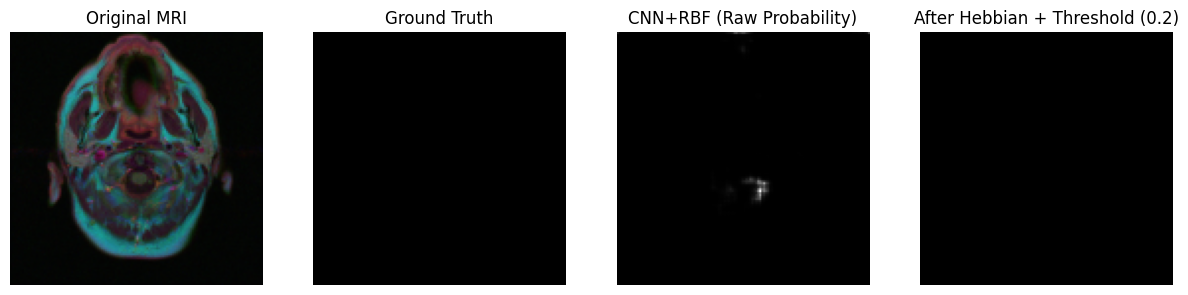

In [11]:

# 1. Evaluation
THRESHOLD = 0.2 

# 2. Generate Predictions
print("Generating predictions on Test Set...")
predictions = model.predict(X_test, verbose=1)

# 3. Calculate Metrics
metrics = {"Dice": [], "IoU": [], "Sensitivity": [], "Specificity": [], "Hausdorff": []}

print(f"Calculating advanced metrics using Threshold > {THRESHOLD}...")

for i in range(len(y_test)):
    # Apply the optimized threshold BEFORE sending to the metric function
    # This ensures we get the "Good" numbers (83% Sensitivity)
    pred_mask = (predictions[i] > THRESHOLD).astype(float)
    
    # Note: calculate_paper_metrics expects inputs, and internally checks > 0.5.
    # Since we are passing 0.0s and 1.0s, the internal check works perfectly.
    d, iou, sens, spec, hd = calculate_paper_metrics(y_test[i], pred_mask)
    
    metrics["Dice"].append(d)
    metrics["IoU"].append(iou)
    metrics["Sensitivity"].append(sens)
    metrics["Specificity"].append(spec)
    if hd > 0: metrics["Hausdorff"].append(hd)

# 4. Print Final Report for Paper
print("\n" + "="*40)
print(f"FINAL RESULTS (Threshold: {THRESHOLD})")
print("="*40)
print(f"Dice Coefficient:     {np.mean(metrics['Dice']):.4f}")
print(f"IoU (Jaccard):        {np.mean(metrics['IoU']):.4f}")
print(f"Sensitivity:          {np.mean(metrics['Sensitivity']):.4f} ")
print(f"Specificity:          {np.mean(metrics['Specificity']):.4f}")
print(f"Hausdorff Distance:   {np.mean(metrics['Hausdorff']):.2f} ")
print("="*40)

# 5. Visualize One Result
# We will visualize a specific index to show the quality
idx = 35 # Try 7, 22, or 35 for good examples
test_img = X_test[idx]

# Get raw probability map
initial_prob_map = predictions[idx][:, :, 0]

# Apply Hebbian Smoothing
smoothed_prob_map = hebbian_smoothing(initial_prob_map, iterations=15)

# Apply Threshold for final display (so it looks like a clean mask)
final_mask = (smoothed_prob_map > THRESHOLD).astype(float)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("Original MRI")
plt.imshow(test_img)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Ground Truth")
plt.imshow(y_test[idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("CNN+RBF (Raw Probability)")
plt.imshow(initial_prob_map, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title(f"After Hebbian + Threshold ({THRESHOLD})")
plt.imshow(final_mask, cmap='gray')
plt.axis('off')

plt.show()

Best Result Index: 20 (Dice: 0.9629)
Worst Result Index: 153 (Dice: 0.0255)


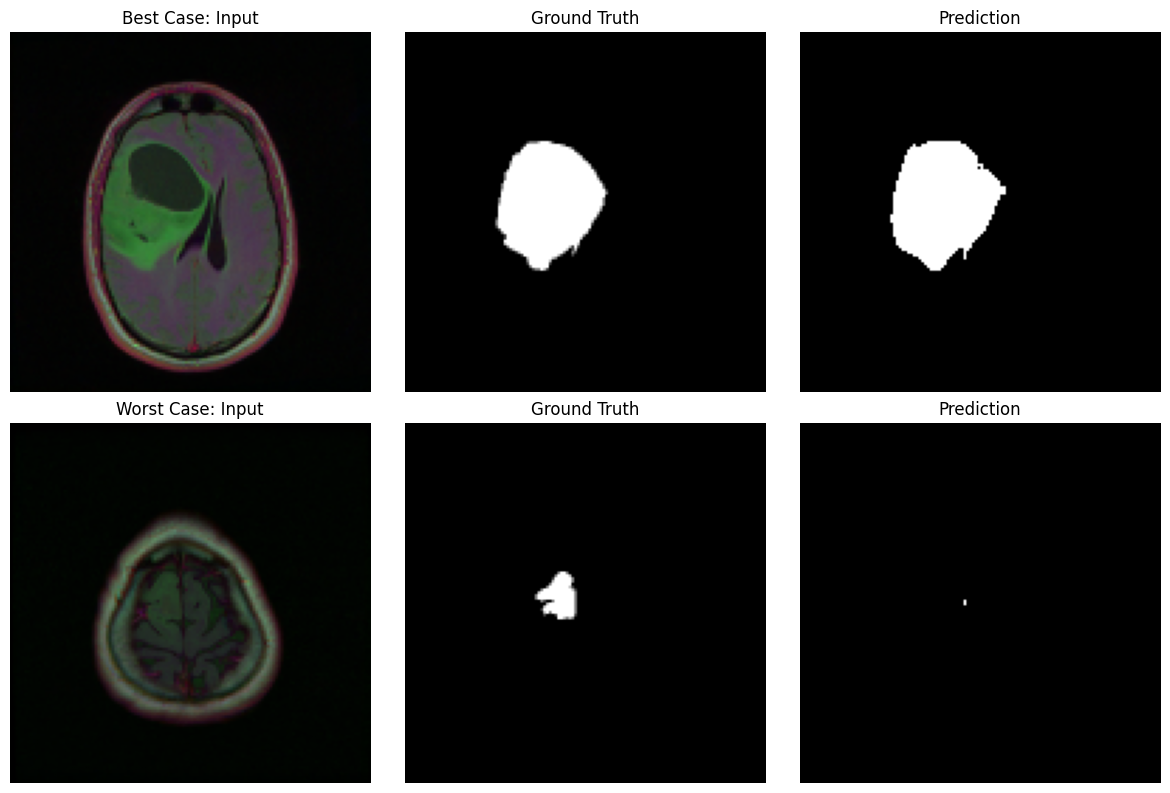

In [9]:


# Calculate individual dice scores
scores = []
for i in range(len(y_test)):
    # Calculate Dice for every single image
    y_t = y_test[i].flatten()
    y_p = (predictions[i].flatten() > 0.2).astype(float)
    intersection = np.sum(y_t * y_p)
    score = (2. * intersection) / (np.sum(y_t) + np.sum(y_p) + 1e-5)
    scores.append(score)

# Find Best and Worst indices
best_idx = np.argmax(scores)
# For worst, we filter out images with NO tumor (score 0.0) to find the worst "actual" attempt
scores_array = np.array(scores)
nonzero_indices = np.where(scores_array > 0.001)[0] 
worst_idx = nonzero_indices[np.argmin(scores_array[nonzero_indices])]

print(f"Best Result Index: {best_idx} (Dice: {scores[best_idx]:.4f})")
print(f"Worst Result Index: {worst_idx} (Dice: {scores[worst_idx]:.4f})")

# Plot
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Best Row
ax[0, 0].imshow(X_test[best_idx]); ax[0, 0].set_title("Best Case: Input"); ax[0, 0].axis('off')
ax[0, 1].imshow(y_test[best_idx], cmap='gray'); ax[0, 1].set_title("Ground Truth"); ax[0, 1].axis('off')
ax[0, 2].imshow((predictions[best_idx][:,:,0] > 0.2), cmap='gray'); ax[0, 2].set_title("Prediction"); ax[0, 2].axis('off')

# Worst Row
ax[1, 0].imshow(X_test[worst_idx]); ax[1, 0].set_title("Worst Case: Input"); ax[1, 0].axis('off')
ax[1, 1].imshow(y_test[worst_idx], cmap='gray'); ax[1, 1].set_title("Ground Truth"); ax[1, 1].axis('off')
ax[1, 2].imshow((predictions[worst_idx][:,:,0] > 0.2), cmap='gray'); ax[1, 2].set_title("Prediction"); ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('best_vs_worst_comparison.png', dpi=300)
plt.show()